In [1]:
import cv2

cap = cv2.VideoCapture(0)  # Windows DirectShow

if not cap.isOpened():
    print("❌ Error: Could not open camera!")
    exit()

ret, frame = cap.read()
if not ret:
    print("❌ Error: Camera opened but failed to capture frame!")
else:
    print("✅ Camera is working! Frame captured.")

cap.release()


✅ Camera is working! Frame captured.


In [2]:
import mediapipe as mp
import numpy as np

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
                       max_num_hands=1,
                       min_detection_confidence=0.6)

def extract_landmarks(image_path):
    """
    Extract hand landmarks from the given image.

    :param image_path: Path to the image file.
    :return: A NumPy array of landmarks.
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        # Extract landmarks for the first hand detected
        landmarks = results.multi_hand_landmarks[0].landmark
        # Convert landmarks to a NumPy array
        landmarks_array = np.array([(lm.x, lm.y, lm.z) for lm in landmarks])
        return landmarks_array
    return None

landmarks = extract_landmarks("hand.jpg")
print(landmarks.shape)

(21, 3)


In [3]:
import pandas as pd

# Read the CSV file
asl_data = pd.read_csv('../asl_dataset/A.csv')

# Display the first few rows of the dataframe
print(asl_data.head())

   A  0.6689752340316772  0.5654740333557129  -5.30485010585835e-07  \
0  A            0.668611            0.565372          -5.277825e-07   
1  A            0.669489            0.566128          -5.282753e-07   
2  A            0.671489            0.568260          -5.294892e-07   
3  A            0.671059            0.567165          -5.322947e-07   
4  A            0.672368            0.568899          -5.233154e-07   

   0.6109158396720886  0.5331746339797974  -0.015173280611634254  \
0            0.610713            0.532992              -0.015437   
1            0.611115            0.534201              -0.015478   
2            0.613247            0.536090              -0.015382   
3            0.612615            0.534281              -0.014610   
4            0.614054            0.535379              -0.015593   

   0.5732476711273193  0.45701250433921814  -0.018423033878207207  ...  \
0            0.572790             0.457128              -0.018826  ...   
1            0.5

In [4]:
data = np.loadtxt("../data/A.csv", delimiter=",")
dataB = np.loadtxt("../data/B.csv", delimiter=",")
points = data[1]


In [5]:
import numpy as np

def get_joint_coordinates(data_row, landmark_index):
    """
    Extracts (x, y, z) coordinates of a specific landmark from a flattened row.
    """
    start = landmark_index * 3
    return np.array(data_row[start:start+3])

# Example: Extract MCP of Index Finger (landmark index 5)
row_data = points  # One row from CSV (63 values)
print(row_data.shape)

(63,)


In [6]:
index_mcp = get_joint_coordinates(row_data, 5)
print("Index MCP Coordinates:", index_mcp)


Index MCP Coordinates: [0.57371914 0.40342432 0.00222244]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the hand connections based on Mediapipe's HAND_CONNECTIONS
hand_connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),   # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),   # Index Finger
    (0, 9), (9, 10), (10, 11), (11, 12), # Middle Finger
    (0, 13), (13, 14), (14, 15), (15, 16), # Ring Finger
    (0, 17), (17, 18), (18, 19), (19, 20), # Little Finger
    (5, 9), (9, 13), (13, 17)  # Palm connections
]


def plot_hand_landmarks(data_row):
    """
    Plots the 21 hand landmarks in a 3D space.
    :param data_row: A 1D array of length 63 containing (x, y, z) values.
    """
    # Ensure data is a NumPy array
    data_row = np.array(data_row).flatten()

    # Extract x, y, z coordinates
    x_values = data_row[0::3]  # Every 3rd value starting from index 0
    y_values = data_row[1::3]  # Every 3rd value starting from index 1
    z_values = data_row[2::3]  # Every 3rd value starting from index 2
    wrist = np.array(get_joint_coordinates(data_row, 0))      # Landmark 0 (wrist)
    index_mcp = np.array(get_joint_coordinates(data_row, 5))   # Landmark 5 (index MCP)
    middle_mcp = np.array(get_joint_coordinates(data_row, 9))   # Landmark 9 (middle MCP)

    # Compute palm orientation vectors
    x_axis, y_axis, z_axis = compute_palm_orientation(wrist, index_mcp, middle_mcp)

    # Plot the 3D landmarks
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_values, y_values, z_values, c='r', marker='o')  # Red dots for landmarks
    # Draw lines connecting the hand landmarks
    for connection in hand_connections:
        i, j = connection
        ax.plot([x_values[i], x_values[j]],
                [y_values[i], y_values[j]],
                [z_values[i], z_values[j]], 'k-')  # Black lines

    # Annotate each landmark index
    for i in range(21):
        ax.text(x_values[i], y_values[i], z_values[i], str(i), color='blue')
    ax.quiver(wrist[0], wrist[1], wrist[2], 
          x_axis[0], x_axis[1], x_axis[2], 
          color='r', length=0.05, normalize=True, label="X-axis")

    ax.quiver(wrist[0], wrist[1], wrist[2], 
            y_axis[0], y_axis[1], y_axis[2], 
            color='g', length=0.05, normalize=True, label="Y-axis")

    ax.quiver(wrist[0], wrist[1], wrist[2], 
            z_axis[0], z_axis[1], z_axis[2], 
            color='b', length=0.05, normalize=True, label="Z-axis")

    # Set axis labels
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    # Label axes
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title("Hand Landmarks in 3D Space")
    # Set axis limits to extend the range

    plt.show()

# Plot the landmarks
plot_hand_landmarks(row_data)


NameError: name 'compute_palm_orientation' is not defined

In [14]:
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of a given vector """
    return vector / np.linalg.norm(vector)

def compute_palm_orientation(wrist, index_mcp, middle_mcp):
    """
    Computes the three basis vectors (z, x, y) for the palm frame.
    :param wrist: (x, y, z) of wrist (landmark 0)
    :param index_mcp: (x, y, z) of index MCP (landmark 5)
    :param middle_mcp: (x, y, z) of middle MCP (landmark 9)
    :return: Normalized x, y, z unit vectors
    """

    # Compute direction vectors from wrist to MCP joints
    p1_p0 = unit_vector(index_mcp - wrist)
    p2_p0 = unit_vector(middle_mcp - wrist)

    # Compute Z-axis (perpendicular to both MCP bones)
    z_axis = unit_vector(np.cross(p1_p0, p2_p0))

    # Compute X-axis (perpendicular to both z-axis and index direction)
    x_axis = unit_vector(np.cross(p1_p0, z_axis))

    # Compute Y-axis (perpendicular to both X and Z to form right-hand system)
    y_axis = unit_vector(np.cross(z_axis, x_axis))

    return x_axis, y_axis, z_axis

# Example: Replace with actual coordinates from a CSV row
wrist = np.array(get_joint_coordinates(row_data, 0))      # Landmark 0 (wrist)
index_mcp = np.array(get_joint_coordinates(row_data, 5))   # Landmark 5 (index MCP)
middle_mcp = np.array(get_joint_coordinates(row_data, 9))   # Landmark 9 (middle MCP)

# Compute palm orientation vectors
x_axis, y_axis, z_axis = compute_palm_orientation(wrist, index_mcp, middle_mcp)

print("X-axis:", x_axis)
print("Y-axis:", y_axis)
print("Z-axis:", z_axis)


X-axis: [-0.91083407  0.40315935  0.08856542]
Y-axis: [-0.4036208  -0.91482773  0.01343385]
Z-axis: [ 0.08643809 -0.02351083  0.99597977]


In [8]:
row_B = dataB[120]
plot_hand_landmarks(row_B)

NameError: name 'compute_palm_orientation' is not defined

In [9]:
import numpy as np

def unit_vector(vector):
    """Returns the unit vector of a given vector."""
    return vector / np.linalg.norm(vector)

def calculate_joint_angle(y_vector, p_next, p_joint, is_pip=False):
    """
    Computes the angle for a given joint using equation (2), 
    excluding the TMC (thumb) and MCP (index, middle, ring, little fingers).

    :param y_vector: The basic Y-axis vector in the local coordinate system.
    :param p_next: The next joint position (p_j+1).
    :param p_joint: The current joint position (p_j).
    :param is_pip: If True, use arccos(), otherwise use arcsin().
    :return: Joint angle in radians.
    """

    v1 = unit_vector(p_next - p_joint)  # Compute the direction vector

    if is_pip:
        # Use dot product for PIP joint angles
        angle = np.arccos(np.clip(np.dot(y_vector, v1), -1.0, 1.0))
    else:
        # Use cross product for other joints
        cross_product_magnitude = np.linalg.norm(np.cross(y_vector, v1))
        angle = np.arcsin(np.clip(cross_product_magnitude, -1.0, 1.0))

    return angle


In [10]:
def compute_all_joint_angles(landmarks):
    """
    Computes joint angles for all 21 hand landmarks, excluding:
    - TMC of Thumb (landmark 1)
    - MCP of Index (5), Middle (9), Ring (13), and Little (17) fingers.

    :param landmarks: A NumPy array of shape (21, 3) containing (x, y, z) for each landmark.
    :return: Dictionary with joint indices as keys and computed angles as values.
    """
    joint_angles = {}  # Dictionary to store angles

    # Y-axis reference vector (assuming global Y-up)
    y_vector = y_axis

    # Define the joints to exclude
    excluded_joints = {1, 5, 9, 13, 17}  # TMC of thumb, MCP of other fingers

    for i in range(21 - 1):  # Avoid accessing out of bounds
        if i in excluded_joints:
            continue  # Skip excluded joints

        p_joint = landmarks[i]  # Current joint position
        p_next = landmarks[i + 1]  # Next joint position

        # Determine if the joint is a PIP joint (affects the angle calculation)
        is_pip = i in {6, 10, 14, 18}  # PIP joints for fingers

        # Compute joint angle
        joint_angles[i] = calculate_joint_angle(y_vector, p_next, p_joint, is_pip=is_pip)

    return joint_angles

# Example: Replace with actual 21x3 landmark data
landmarks = row_B.reshape((21,3))  # Simulated hand landmarks (random values)

# Compute all joint angles
joint_angles = compute_all_joint_angles(landmarks)

# Print results
for joint, angle in joint_angles.items():
    print(f"Joint {joint}: {np.degrees(angle):.2f}°")


NameError: name 'y_axis' is not defined

In [11]:
import numpy as np

def project_onto_yz(landmark):
    """ Projects a 3D point onto the YZ plane by setting X to 0. """
    return np.array([0, landmark[1], landmark[2]])

def calculate_excluded_joint_angles(y_vector, p_next, p_joint):
    """
    Computes yaw and roll angles for the excluded joints:
    - Thumb TMC (landmark 1)
    - MCP of Index (5), Middle (9), Ring (13), and Little (17)

    :param y_vector: The reference Y-axis vector in the local coordinate system.
    :param p_next: The next joint position (p_j+1).
    :param p_joint: The current joint position (p_j).
    :return: Tuple (yaw_angle, roll_angle) in radians.
    """
    # Project p_next onto the YZ plane
    p_next_projected = project_onto_yz(p_next)

    # Compute yaw using equation (3)
    cross_y_p = np.cross(y_vector, p_next_projected - p_joint)
    yaw = np.arcsin(np.clip(np.linalg.norm(cross_y_p), -1.0, 1.0))

    # Compute roll using equation (3)
    cross_p = np.cross(p_next_projected - p_joint, p_next - p_joint)
    roll = np.arcsin(np.clip(np.linalg.norm(cross_p), -1.0, 1.0))

    return yaw, roll


In [12]:

# Compute yaw and roll angles for an excluded joint
yaw_angle, roll_angle = calculate_excluded_joint_angles(y_axis, get_joint_coordinates(row_B, 1), get_joint_coordinates(row_B, 2))

print(f"Yaw Angle: {np.degrees(yaw_angle):.2f}°")
print(f"Roll Angle: {np.degrees(roll_angle):.2f}°")


NameError: name 'y_axis' is not defined

In [52]:
def compute_excluded_joints_angles(landmarks):
    """
    Computes yaw and roll angles for the excluded joints:
    - Thumb TMC (landmark 1)
    - MCP of Index (5), Middle (9), Ring (13), and Little (17)

    :param landmarks: A NumPy array of shape (21, 3) containing (x, y, z) for each landmark.
    :return: Dictionary with joint indices as keys and (yaw, roll) angles as values.
    """
    if landmarks.shape != (21, 3):
        raise ValueError(f"Invalid landmarks shape: {landmarks.shape}, expected (21,3)")

    excluded_joints = {1, 5, 9, 13, 17}  # TMC and MCP joints
    joint_angles = {}

    # Reference Y-axis vector (assuming global Y-up)
    y_vector = np.array([0, 1, 0])

    for joint in excluded_joints:
        if joint + 1 >= 21:  # Ensure we don't exceed landmark indices
            continue

        p_joint = landmarks[joint]  # Current joint position
        p_next = landmarks[joint + 1]  # Next joint position

        # Compute yaw and roll using the function
        yaw, roll = calculate_excluded_joint_angles(y_vector, p_next, p_joint)

        # Store in dictionary
        joint_angles[joint] = {"yaw": np.degrees(yaw), "roll": np.degrees(roll)}

    return joint_angles


In [54]:
compute_excluded_joints_angles(row_data.reshape((21,3)))

{1: {'yaw': 35.69440143238155, 'roll': 1.9292605380489194},
 17: {'yaw': 42.87646825146283, 'roll': 1.329880762160272},
 5: {'yaw': 35.04599058233685, 'roll': 1.2571542934581488},
 9: {'yaw': 37.46765064396138, 'roll': 1.2849704599069665},
 13: {'yaw': 40.09307005981741, 'roll': 1.480442974922262}}

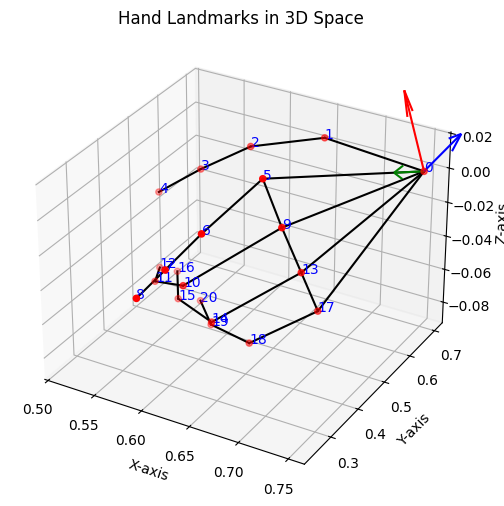

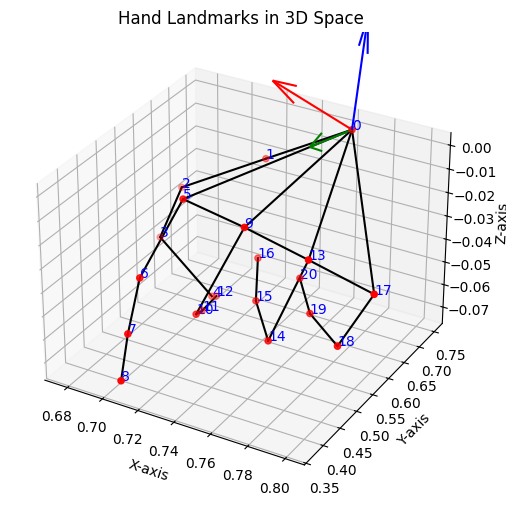

In [15]:
data1 = np.loadtxt("../data/D.csv", delimiter=",")
dataD = np.loadtxt("../data/1.csv", delimiter=",")
row_D = data1[1]
row_1 = dataD[1]
plot_hand_landmarks(row_D)
plot_hand_landmarks(row_1)